In [16]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Imports
import json
import os
from tqdm import tqdm

In [32]:

# File paths
start_index = 301
end_index = 400
range_tag = f"{start_index}-{end_index}"
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
INFERENCE_PATH = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")

STEPS_PATH = os.path.join(BASE_PATH, f"output/identify_error_step/0524/step_comparison_deepseek7b-math-{range_tag}.json")

OUTPUT_PATH = os.path.join(BASE_PATH, f"output/stat_logits/0524/stat_logits_deepseek7b-math-{range_tag}.json")


In [33]:
# Load JSON data
with open(INFERENCE_PATH, 'r') as f:
    logits_data = json.load(f)

with open(STEPS_PATH, 'r') as f:
    steps_data = json.load(f)


In [20]:
# Helper function to compute average token probability
def compute_avg_logit(step_logits):
    if not step_logits:
        return None
    return sum(tok['prob'] for tok in step_logits) / len(step_logits)


In [ ]:
# Add avg_logits to each fix_step / error_step entry
for qid, entry in tqdm(steps_data.items()):
  if qid == "omitted":
    continue
  for s_type in ['correct_sampling', 'wrong_sampling']:
      for sampling_key, comparisons in entry.get(s_type, {}).items():
          for vs_key, info in comparisons.items():
              if s_type == "correct_sampling" and "fix_step" in info:
                  step = str(info["fix_step"])
                  step_logits = logits_data[qid].get(sampling_key, {}).get("step_token_probs", []).get(step, {})
                  info["avg_logits"] = compute_avg_logit(step_logits)
              elif s_type == "wrong_sampling" and "error_step" in info:
                  step = str(info["error_step"])
                  step_logits = logits_data[qid].get(sampling_key, {}).get("step_token_probs", []).get(step, {})
                  info["avg_logits"] = compute_avg_logit(step_logits)


100%|██████████| 2/2 [00:00<00:00, 6423.13it/s]


In [ ]:
# Save output
with open(OUTPUT_PATH, "w") as f:
    json.dump(steps_data, f, indent=2)

print("✅ Saved to", OUTPUT_PATH)


✅ Saved to /content/drive/MyDrive/Cluster-proj/output/stat_logits/stat_logits_deepseek7b-math-651-655.json


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 60/60 [00:00<00:00, 21734.02it/s]


✅ Saved JSON to /content/drive/MyDrive/Cluster-proj/output/stat_logits/0524/stat_logits_deepseek7b-math-401-600.json


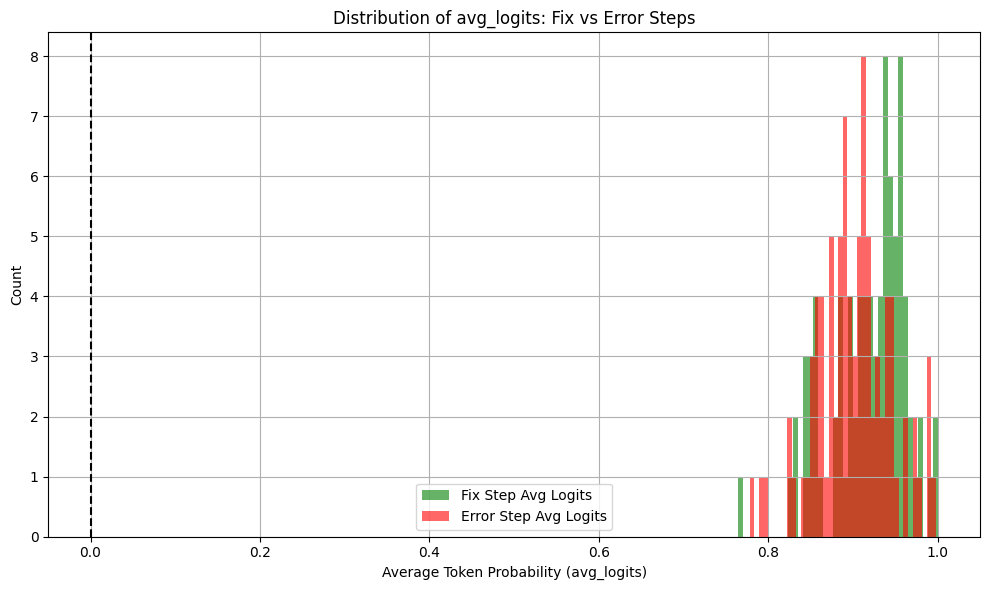

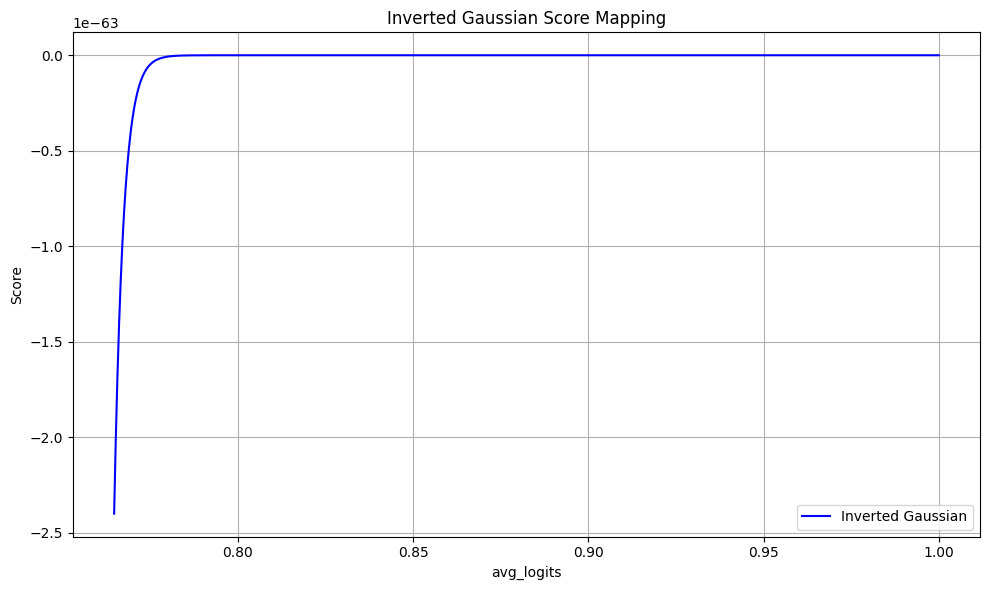

📊 Stats CSV saved.


In [37]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# File paths
start_index = 401
end_index = 600
range_tag = f"{start_index}-{end_index}"
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"

INFERENCE_PATH = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")

STEPS_PATH = os.path.join(BASE_PATH, f"output/identify_error_step/0524/step_comparison_deepseek7b-math-{range_tag}.json")

OUTPUT_PATH = os.path.join(BASE_PATH, f"output/stat_logits/0524/stat_logits_deepseek7b-math-{range_tag}.json")
# Load JSON data
with open(INFERENCE_PATH, 'r') as f:
    logits_data = json.load(f)
with open(STEPS_PATH, 'r') as f:
    steps_data = json.load(f)

# Helper: compute average token probability
def compute_avg_logit(step_logits):
    if not step_logits:
        return None
    return sum(tok['prob'] for tok in step_logits) / len(step_logits)

# Containers for stats
fix_logits = []
error_logits = []

# Add avg_logits to each fix_step / error_step entry
for qid, entry in tqdm(steps_data.items()):
    if qid == "omitted":
        continue
    for s_type in ['correct_sampling', 'wrong_sampling']:
        for sampling_key, comparisons in entry.get(s_type, {}).items():
            for vs_key, info in comparisons.items():
                if s_type == "correct_sampling" and "fix_step" in info:
                    step = str(info["fix_step"])
                    step_logits = logits_data[qid].get(sampling_key, {}).get("step_token_probs", {}).get(step, {})
                    avg_logit = compute_avg_logit(step_logits)
                    info["avg_logits"] = avg_logit
                    if avg_logit is not None:
                        fix_logits.append(avg_logit)
                elif s_type == "wrong_sampling" and "error_step" in info:
                    step = str(info["error_step"])
                    step_logits = logits_data[qid].get(sampling_key, {}).get("step_token_probs", {}).get(step, {})
                    avg_logit = compute_avg_logit(step_logits)
                    info["avg_logits"] = avg_logit
                    if avg_logit is not None:
                        error_logits.append(avg_logit)

# Save JSON output
with open(OUTPUT_PATH, "w") as f:
    json.dump(steps_data, f, indent=2)
print("✅ Saved JSON to", OUTPUT_PATH)

# ==== 分析和可视化 ====

# 倒高斯函数
def inverted_gaussian(x, mu=0, sigma=1):
    return -np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# 转为 numpy
fix_logits_np = np.array(fix_logits)
error_logits_np = np.array(error_logits)

# 合并估计 sigma
combined = np.concatenate([fix_logits_np, error_logits_np])
sigma_est = np.std(combined)

# 倒高斯得分
fix_scores = inverted_gaussian(fix_logits_np, mu=0, sigma=sigma_est)
error_scores = inverted_gaussian(error_logits_np, mu=0, sigma=sigma_est)

# 可视化直方图
plt.figure(figsize=(10, 6))
plt.hist(fix_logits_np, bins=40, alpha=0.6, label='Fix Step Avg Logits', color='green')
plt.hist(error_logits_np, bins=40, alpha=0.6, label='Error Step Avg Logits', color='red')
plt.axvline(0, linestyle='--', color='black')
plt.xlabel('Average Token Probability (avg_logits)')
plt.ylabel('Count')
plt.title('Distribution of avg_logits: Fix vs Error Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 倒高斯映射函数可视化
x_vals = np.linspace(min(combined), max(combined), 500)
y_vals = inverted_gaussian(x_vals, mu=0, sigma=sigma_est)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label="Inverted Gaussian", color="blue")
plt.title("Inverted Gaussian Score Mapping")
plt.xlabel("avg_logits")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 保存统计结果表格（可选）
df_stats = pd.DataFrame({
    "fix_logits": fix_logits_np,
    "fix_score": fix_scores
}).rename_axis("fix_id").reset_index()

df_stats2 = pd.DataFrame({
    "error_logits": error_logits_np,
    "error_score": error_scores
}).rename_axis("error_id").reset_index()

df_stats.to_csv(os.path.join(BASE_PATH, f"output/stat_logits/fix_step_stats_{range_tag}.csv"), index=False)
df_stats2.to_csv(os.path.join(BASE_PATH, f"output/stat_logits/error_step_stats_{range_tag}.csv"), index=False)

print("📊 Stats CSV saved.")


In [24]:
fix_scores

array([-9.03914336e-111, -1.88356883e-090, -1.11146855e-083,
       -7.25718753e-088, -4.41317506e-096, -4.41317506e-096,
       -7.25889735e-105, -1.74344706e-109, -1.74344706e-109,
       -1.03461738e-106, -8.61339808e-106, -1.09023300e-109,
       -2.34857955e-102, -4.91985275e-106, -9.30661395e-093,
       -5.40582962e-101, -1.61125103e-078, -5.99093971e-092,
       -2.59944543e-101, -1.45666844e-096, -2.57287525e-108,
       -4.09869717e-077, -6.59472270e-082, -1.20245049e-088,
       -5.55208976e-095, -7.08650222e-087, -2.27691555e-106,
       -6.80701858e-100, -4.08105403e-092, -3.85924716e-096,
       -4.29514421e-108, -2.32074269e-096, -2.57538710e-108,
       -1.16994603e-099, -1.86744821e-108, -3.32306093e-088,
       -1.12050796e-095, -1.07372902e-095, -9.60895524e-103,
       -2.09273527e-089, -1.56319532e-079, -1.66217987e-110,
       -6.36381384e-102, -1.36244670e-108, -2.22571513e-105,
       -3.92524077e-111, -3.92524077e-111, -3.31992964e-091,
       -1.33262024e-095]

In [ ]:
fix_logits_np

array([0.94314188, 0.92059896])

(array([7., 4., 4., 3., 1., 1., 2., 3., 1., 0., 3., 2., 2., 4., 0., 0., 0.,
        0., 2., 3., 0., 1., 3., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.]),
 array([-0.9998614 , -0.97632479, -0.95278819, -0.92925158, -0.90571497,
        -0.88217837, -0.85864176, -0.83510516, -0.81156855, -0.78803195,
        -0.76449534, -0.74095873, -0.71742213, -0.69388552, -0.67034892,
        -0.64681231, -0.62327571, -0.5997391 , -0.57620249, -0.55266589,
        -0.52912928, -0.50559268, -0.48205607, -0.45851947, -0.43498286,
        -0.41144625, -0.38790965, -0.36437304, -0.34083644, -0.31729983,
        -0.29376323, -0.27022662, -0.24669001, -0.22315341, -0.1996168 ,
        -0.1760802 , -0.15254359, -0.12900699, -0.10547038, -0.08193377,
        -0.05839717]),
 <BarContainer object of 40 artists>)

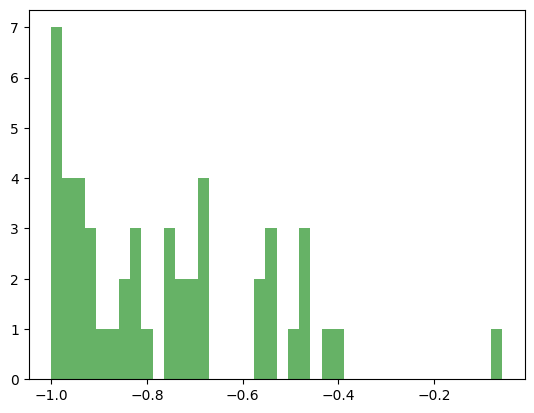

In [35]:
# mu_est = np.mean(combined)  # or np.median(combined)
mu_est = np.mean(fix_logits_np)
fix_scores = inverted_gaussian(fix_logits_np, mu=mu_est, sigma=sigma_est)
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Scores', color='green')

(array([8., 3., 4., 3., 0., 0., 0., 0., 3., 3., 0., 2., 1., 1., 2., 1., 2.,
        0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 2., 2., 1., 1., 2.]),
 array([-0.99934927, -0.97439657, -0.94944387, -0.92449117, -0.89953847,
        -0.87458577, -0.84963307, -0.82468038, -0.79972768, -0.77477498,
        -0.74982228, -0.72486958, -0.69991688, -0.67496418, -0.65001148,
        -0.62505878, -0.60010608, -0.57515338, -0.55020068, -0.52524798,
        -0.50029528, -0.47534258, -0.45038989, -0.42543719, -0.40048449,
        -0.37553179, -0.35057909, -0.32562639, -0.30067369, -0.27572099,
        -0.25076829, -0.22581559, -0.20086289, -0.17591019, -0.15095749,
        -0.12600479, -0.1010521 , -0.0760994 , -0.0511467 , -0.026194  ,
        -0.0012413 ]),
 <BarContainer object of 40 artists>)

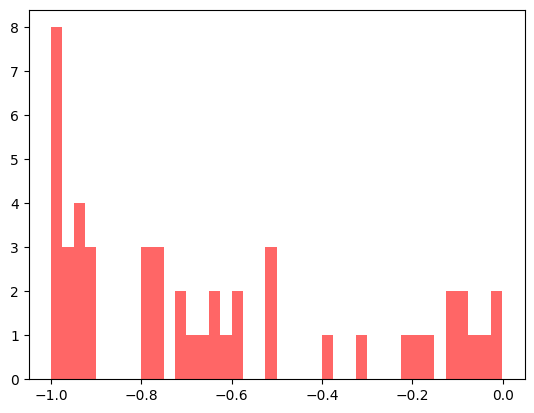

In [36]:
# mu_est = np.mean(combined)  # or np.median(combined)
mu_est_error = np.mean(error_logits_np)
error_scores = inverted_gaussian(error_logits_np, mu=mu_est, sigma=sigma_est)
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Scores', color='red')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing 401-600: 100%|██████████| 60/60 [00:00<00:00, 23018.22it/s]


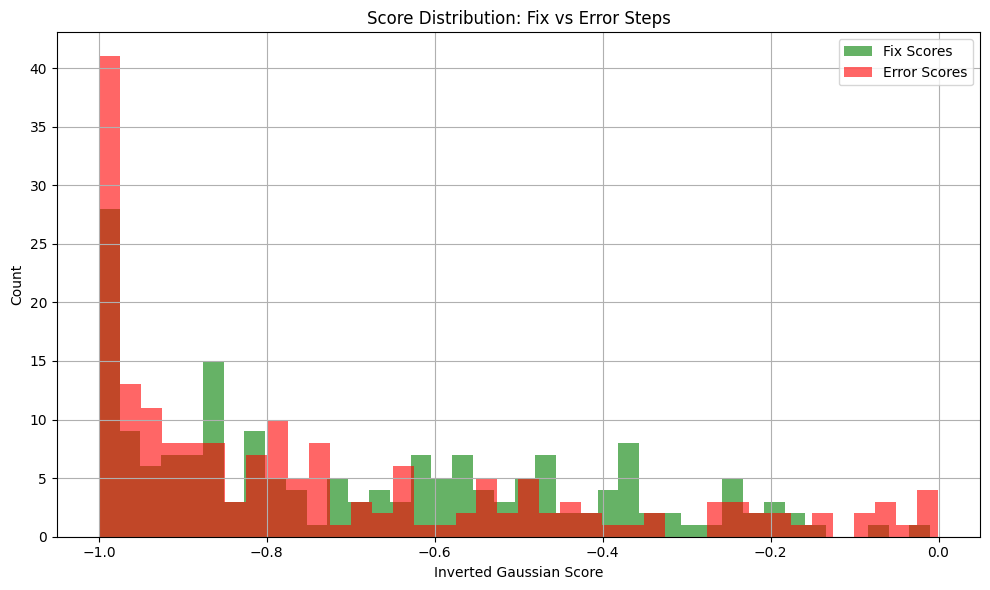

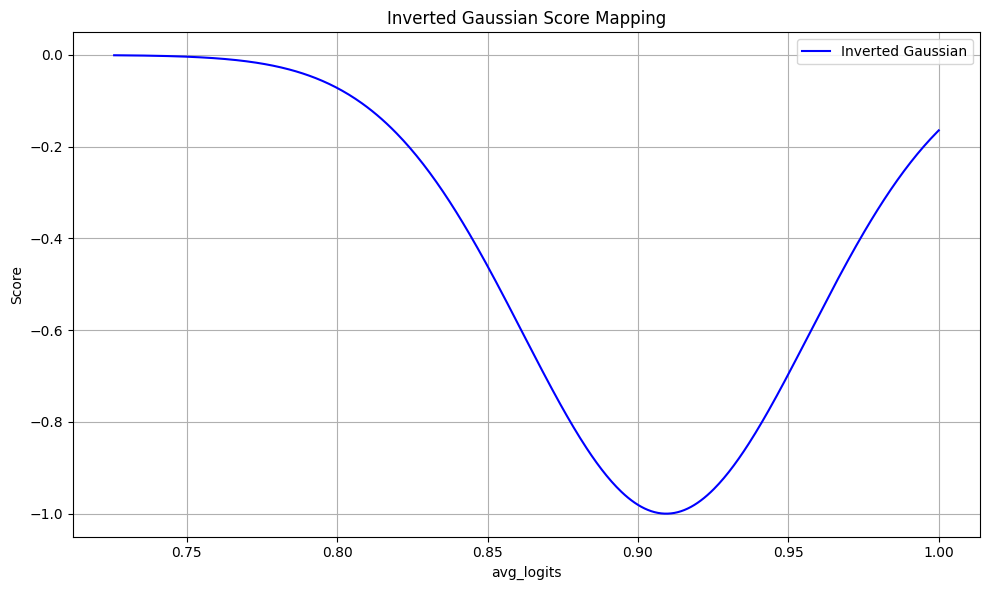

📊 Merged Stats CSV saved.


In [38]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# ========== 支持多个区间 ==========
intervals = [(201, 300), (301, 400), (401, 600)]
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"

fix_logits = []
error_logits = []

# Helper: compute average token probability
def compute_avg_logit(step_logits):
    if not step_logits:
        return None
    return sum(tok['prob'] for tok in step_logits) / len(step_logits)

for start_index, end_index in intervals:
    range_tag = f"{start_index}-{end_index}"

    INFERENCE_PATH = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")
    STEPS_PATH = os.path.join(BASE_PATH, f"output/identify_error_step/0524/step_comparison_deepseek7b-math-{range_tag}.json")

    with open(INFERENCE_PATH, 'r') as f:
        logits_data = json.load(f)
    with open(STEPS_PATH, 'r') as f:
        steps_data = json.load(f)

    for qid, entry in tqdm(steps_data.items(), desc=f"Processing {range_tag}"):
        if qid == "omitted":
            continue
        for s_type in ['correct_sampling', 'wrong_sampling']:
            for sampling_key, comparisons in entry.get(s_type, {}).items():
                for vs_key, info in comparisons.items():
                    if s_type == "correct_sampling" and "fix_step" in info:
                        step = str(info["fix_step"])
                        step_logits = logits_data[qid].get(sampling_key, {}).get("step_token_probs", {}).get(step, {})
                        avg_logit = compute_avg_logit(step_logits)
                        info["avg_logits"] = avg_logit
                        if avg_logit is not None:
                            fix_logits.append(avg_logit)
                    elif s_type == "wrong_sampling" and "error_step" in info:
                        step = str(info["error_step"])
                        step_logits = logits_data[qid].get(sampling_key, {}).get("step_token_probs", {}).get(step, {})
                        avg_logit = compute_avg_logit(step_logits)
                        info["avg_logits"] = avg_logit
                        if avg_logit is not None:
                            error_logits.append(avg_logit)

# ========== 分析和可视化 ==========

# 倒高斯函数
def inverted_gaussian(x, mu=0, sigma=1):
    return -np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# 转为 numpy
fix_logits_np = np.array(fix_logits)
error_logits_np = np.array(error_logits)

# 合并估计 mu/sigma
combined = np.concatenate([fix_logits_np, error_logits_np])
mu_est = np.mean(combined)
sigma_est = np.std(combined)

# 倒高斯得分
fix_scores = inverted_gaussian(fix_logits_np, mu=mu_est, sigma=sigma_est)
error_scores = inverted_gaussian(error_logits_np, mu=mu_est, sigma=sigma_est)

# 可视化直方图
plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Scores', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Scores', color='red')
plt.xlabel('Inverted Gaussian Score')
plt.ylabel('Count')
plt.title('Score Distribution: Fix vs Error Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 倒高斯函数映射图
x_vals = np.linspace(min(combined), max(combined), 500)
y_vals = inverted_gaussian(x_vals, mu=mu_est, sigma=sigma_est)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label="Inverted Gaussian", color="blue")
plt.title("Inverted Gaussian Score Mapping")
plt.xlabel("avg_logits")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 保存统计结果
df_stats = pd.DataFrame({
    "fix_logits": fix_logits_np,
    "fix_score": fix_scores
}).rename_axis("fix_id").reset_index()

df_stats2 = pd.DataFrame({
    "error_logits": error_logits_np,
    "error_score": error_scores
}).rename_axis("error_id").reset_index()

df_stats.to_csv(os.path.join(BASE_PATH, f"output/stat_logits/fix_step_stats_merged.csv"), index=False)
df_stats2.to_csv(os.path.join(BASE_PATH, f"output/stat_logits/error_step_stats_merged.csv"), index=False)

print("📊 Merged Stats CSV saved.")


Processing 401-600: 100%|██████████| 60/60 [00:00<00:00, 3096.87it/s]

✅ CSV saved to: /content/drive/MyDrive/Cluster-proj/output/stat_logits/0524/step_level_token_stats_merged_200_600.csv


<Figure size 1000x600 with 0 Axes>

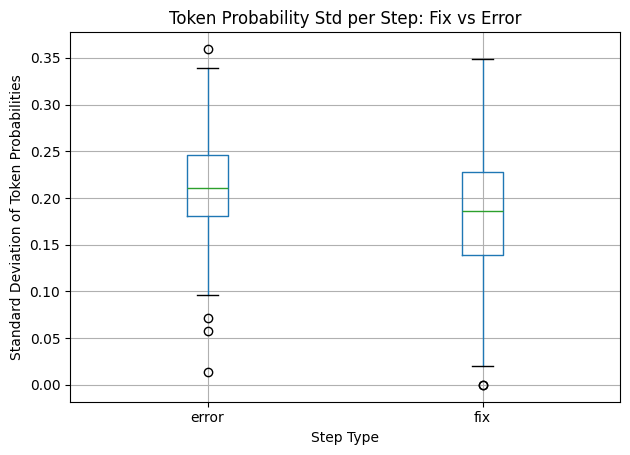

In [56]:
# ========== 📦 Imports ==========
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========== 📂 配置 ==========
intervals = [(201, 300), (301, 400), (401, 600)]
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"  # 替换为你的本地路径或 Colab 挂载路径
OUTPUT_DIR = os.path.join(BASE_PATH, "output/stat_logits/0524")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ========== 🧠 倒高斯函数 ==========
def inverted_gaussian(x, mu=0, sigma=1):
    return -np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# ========== 📊 存储每个step的统计信息 ==========
step_stats = []

# ========== 🔁 合并处理所有区间 ==========
for start_index, end_index in intervals:
    range_tag = f"{start_index}-{end_index}"
    INFERENCE_PATH = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")
    STEPS_PATH = os.path.join(BASE_PATH, f"output/identify_error_step/0524/step_comparison_deepseek7b-math-{range_tag}.json")

    with open(INFERENCE_PATH, 'r') as f:
        logits_data = json.load(f)
    with open(STEPS_PATH, 'r') as f:
        steps_data = json.load(f)

    for qid, entry in tqdm(steps_data.items(), desc=f"Processing {range_tag}"):
        if qid == "omitted":
            continue
        for s_type in ['correct_sampling', 'wrong_sampling']:
            for sampling_key, comparisons in entry.get(s_type, {}).items():
                for vs_key, info in comparisons.items():
                    step_key = "fix_step" if s_type == "correct_sampling" else "error_step"
                    if step_key in info:
                        step = str(info[step_key])
                        token_probs = logits_data[qid].get(sampling_key, {}).get("step_token_probs", {}).get(step, [])
                        if not token_probs:
                            continue
                        probs = [tok["prob"] for tok in token_probs if "prob" in tok]
                        if not probs:
                            continue
                        step_stats.append({
                            "qid": qid,
                            "step": step,
                            "sampling_id": sampling_key,
                            "type": "fix" if step_key == "fix_step" else "error",
                            "min_prob": np.min(probs),
                            "max_prob": np.max(probs),
                            "mean_prob": np.mean(probs),
                            "std_prob": np.std(probs),
                            "conf_span": np.max(probs) - np.min(probs),
                            "probs": probs
                        })

# ========== 📈 高斯参数估计 ==========
df_steps = pd.DataFrame(step_stats)
all_token_probs = np.concatenate(df_steps["probs"].values)
mu_est = np.mean(all_token_probs)
sigma_est = np.std(all_token_probs)

# ========== 📉 倒高斯打分 ==========
df_steps["avg_inverted_score"] = df_steps["probs"].apply(
    lambda probs: np.mean(inverted_gaussian(np.array(probs), mu=mu_est, sigma=sigma_est))
)

# ========== 💾 保存CSV ==========
output_csv = os.path.join(OUTPUT_DIR, "step_level_token_stats_merged_200_600.csv")
df_steps.drop(columns=["probs"]).to_csv(output_csv, index=False)
print(f"✅ CSV saved to: {output_csv}")

# ========== 📊 可视化：标准差对比 ==========
plt.figure(figsize=(10, 6))
df_steps.boxplot(column="std_prob", by="type")
plt.title("Token Probability Std per Step: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Standard Deviation of Token Probabilities")
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
df_steps

,qid,step,sampling_id,type,min_prob,max_prob,mean_prob,std_prob,conf_span,probs,avg_inverted_score
0,q_206,6,sampling1,fix,0.574481,1.0,0.978915,0.078912,0.425519,"[1.0, 0.957912266254425, 1.0, 0.86180418729782...",-0.895126
1,q_206,3,sampling1,fix,0.179862,1.0,0.883932,0.250097,0.820138,"[1.0, 0.21506790816783905, 0.5720393657684326,...",-0.783158
2,q_206,3,sampling0,error,0.123698,1.0,0.964929,0.120305,0.876302,"[1.0, 0.7849321365356445, 1.0, 0.7129498720169...",-0.888205
3,q_206,2,sampling2,error,0.030417,1.0,0.749436,0.332074,0.969583,"[1.0, 0.030417364090681076, 0.129670649766922,...",-0.670949
4,q_208,1,sampling1,fix,0.060339,1.0,0.849925,0.269705,0.939661,"[1.0, 0.9511421918869019, 1.0, 1.0, 0.95009434...",-0.755332
...,...,...,...,...,...,...,...,...,...,...,...
363,q_594,5,sampling2,error,0.255132,1.0,0.876674,0.224855,0.744868,"[1.0, 1.0, 0.7849321365356445, 1.0, 0.26141646...",-0.754418
364,q_597,2,sampling0,fix,0.850823,1.0,0.991569,0.029400,0.149177,"[1.0, 0.9383825659751892, 0.8508228659629822, ...",-0.920049
365,q_597,2,sampling1,fix,0.890729,1.0,0.994971,0.022248,0.109271,"[1.0, 1.0, 0.8907294273376465, 1.0, 1.0, 1.0, ...",-0.918048
366,q_597,1,sampling2,error,0.138196,1.0,0.873650,0.242202,0.861804,"[1.0, 0.47528427839279175, 0.8769960999488831,...",-0.777737


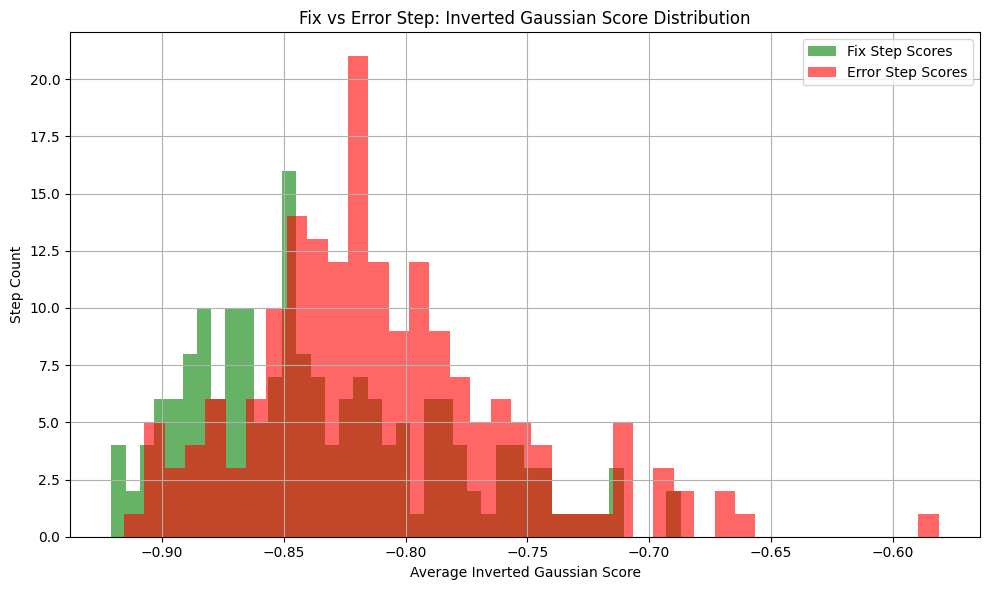

In [58]:
# 分离 fix 和 error 的倒高斯得分
fix_scores = df_steps[df_steps["type"] == "fix"]["avg_inverted_score"].values
error_scores = df_steps[df_steps["type"] == "error"]["avg_inverted_score"].values

# 绘图
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Step Scores', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Step Scores', color='red')
plt.xlabel('Average Inverted Gaussian Score')
plt.ylabel('Step Count')
plt.title('Fix vs Error Step: Inverted Gaussian Score Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

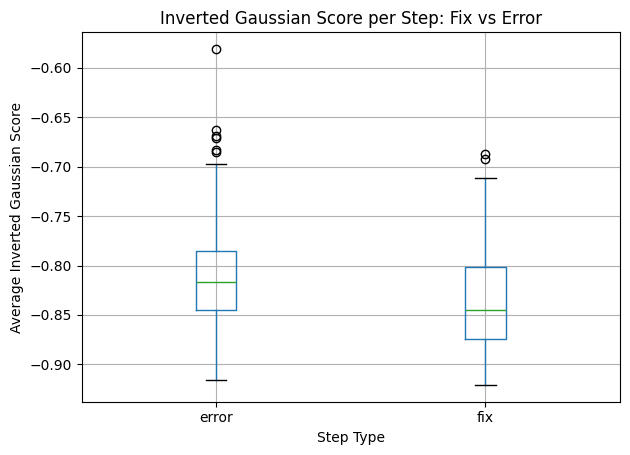

In [59]:
# ========== 📊 可视化：倒高斯打分 Fix vs Error ==========
plt.figure(figsize=(10, 6))
df_steps.boxplot(column="avg_inverted_score", by="type")
plt.title("Inverted Gaussian Score per Step: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Average Inverted Gaussian Score")
plt.grid(True)
plt.tight_layout()
plt.show()


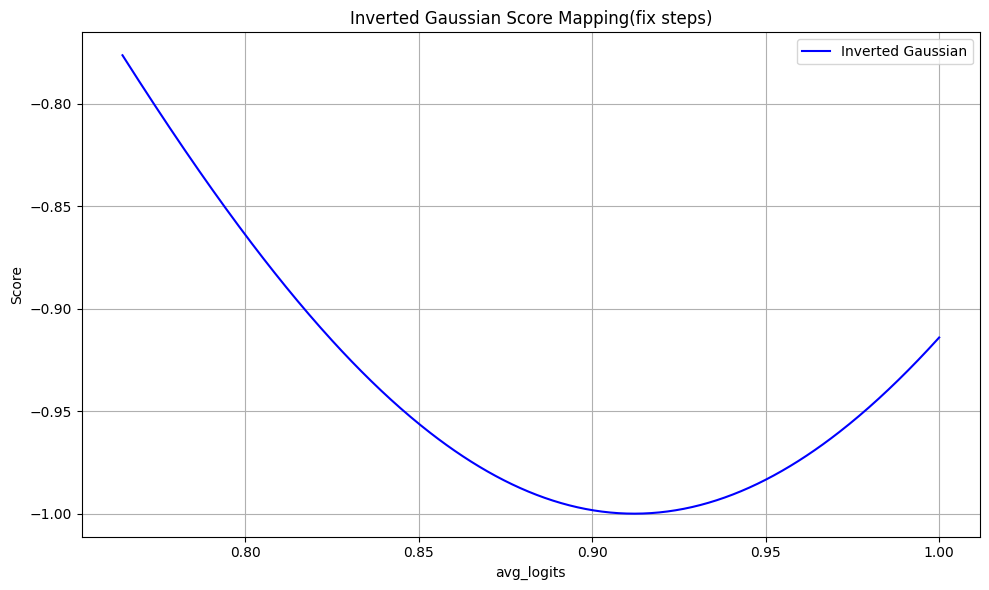

In [62]:

# ========== 📉 倒高斯函数映射图（基于 fix_step 的 mean_prob） ==========
fix_mean_logits = df_steps[df_steps["type"] == "fix"]["mean_prob"].values
x_vals = np.linspace(min(fix_mean_logits), max(fix_mean_logits), 500)
y_vals = inverted_gaussian(x_vals, mu=mu_est, sigma=sigma_est)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label="Inverted Gaussian", color="blue")
plt.title("Inverted Gaussian Score Mapping(fix steps)")
plt.xlabel("avg_logits")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


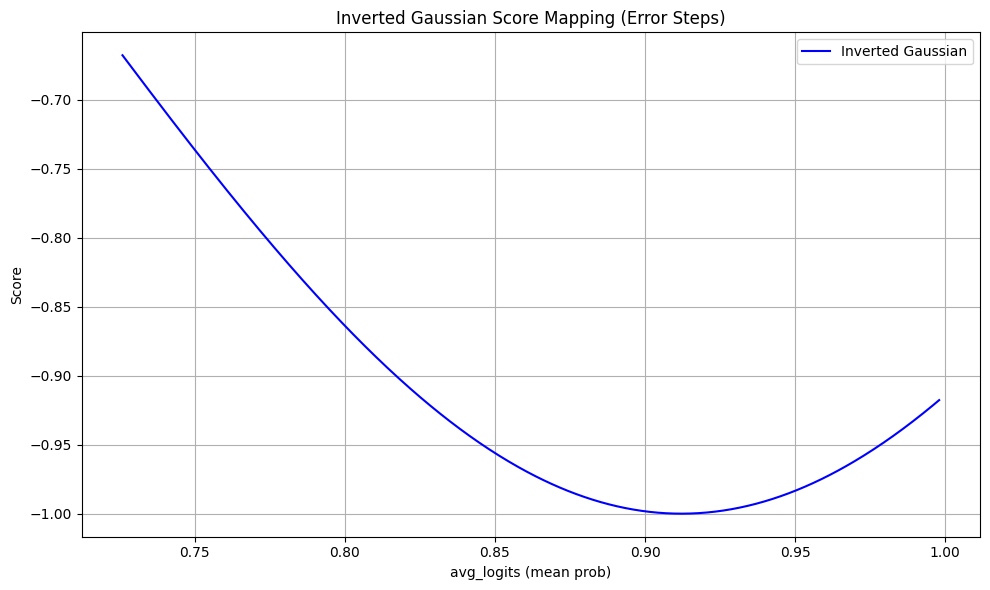

In [61]:
# ========== 📉 倒高斯函数映射图（基于 error_step 的 mean_prob） ==========
error_mean_logits = df_steps[df_steps["type"] == "error"]["mean_prob"].values
x_vals = np.linspace(min(error_mean_logits), max(error_mean_logits), 500)
y_vals = inverted_gaussian(x_vals, mu=mu_est, sigma=sigma_est)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label="Inverted Gaussian", color="blue")
plt.title("Inverted Gaussian Score Mapping (Error Steps)")
plt.xlabel("avg_logits (mean prob)")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


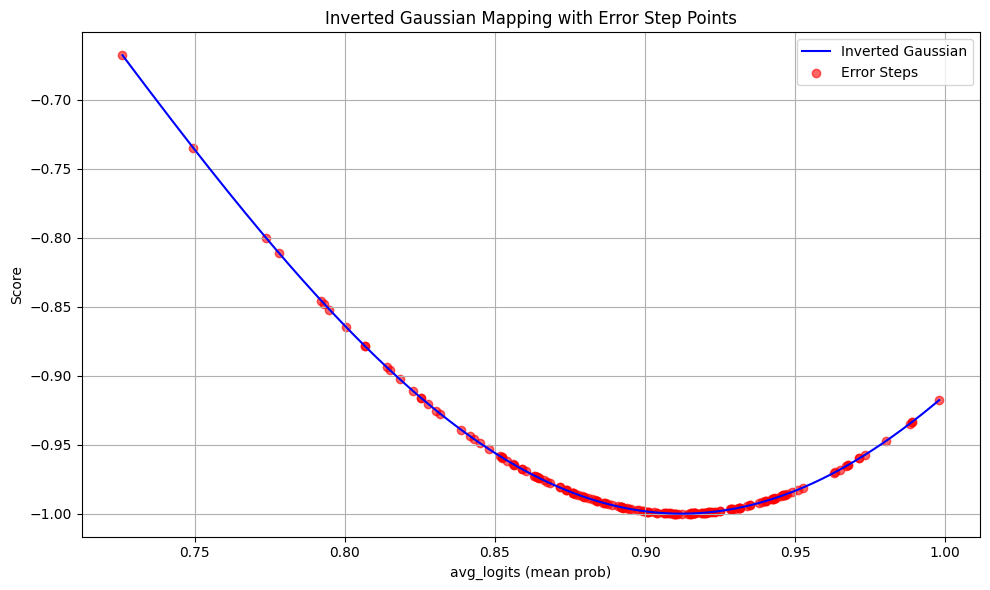

In [63]:
plt.figure(figsize=(10, 6))
x_vals = np.linspace(min(error_mean_logits), max(error_mean_logits), 500)
y_vals = inverted_gaussian(x_vals, mu=mu_est, sigma=sigma_est)

# 绘制倒高斯函数
plt.plot(x_vals, y_vals, label="Inverted Gaussian", color="blue")

# 🔴 叠加 error step 的点
plt.scatter(
    error_mean_logits,
    inverted_gaussian(error_mean_logits, mu=mu_est, sigma=sigma_est),
    color="red",
    alpha=0.6,
    label="Error Steps"
)

plt.title("Inverted Gaussian Mapping with Error Step Points")
plt.xlabel("avg_logits (mean prob)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
